## Importing Libraries and Reading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import nltk
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# manually unzip wordnet since it was giving errors otherwise
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
stopwords = set(stopwords.words('english'))

import re
import string

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

import time
from time import time

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/

In [2]:
tweets = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [3]:
print("Train shape: ", tweets.shape)
print("Test shape ", test_data.shape)

Train shape:  (7613, 5)
Test shape  (3263, 4)


In [4]:
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


`keyword` and `location` coulumns have a lot of missing values. But the `text` and `target` columns both have 7613 entries. Those are the columns we are concerned with. Just to confirm, we will check the `text` and `target` columns for NULL values.

In [6]:
tweets.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

## Explratory Data Analysis
Analyzing the target variable

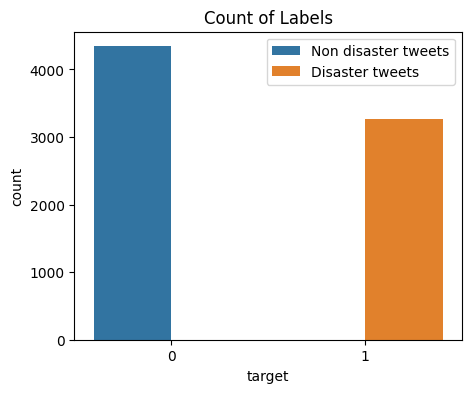

In [7]:
plt.figure(figsize=(5,4))
sns.countplot(x = 'target', data = tweets, hue='target')

plt.title('Count of Labels')
plt.legend(labels=['Non disaster tweets', 'Disaster tweets'])
plt.show()

We can see that the tweets are fairly evenly distributed between the two classes. Next we will look at the total number of words per tweet

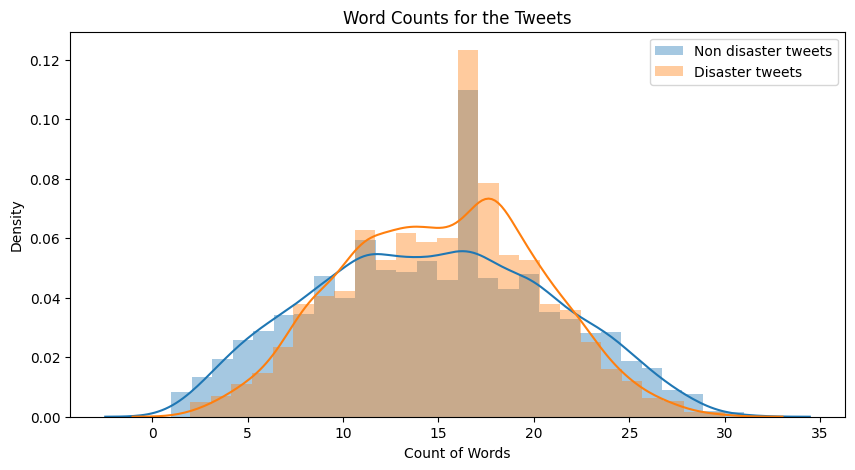

In [8]:
tweets['Count of Words'] = tweets['text'].apply(lambda x: len(x.split()))

fig, ax = plt.subplots(figsize = (10, 5))
sns.distplot(tweets[tweets['target']==0]['Count of Words'], label = "Non disaster tweets")
sns.distplot(tweets[tweets['target']==1]['Count of Words'], label = "Disaster tweets")

plt.title('Word Counts for the Tweets')
plt.legend()
plt.show()

There doesn't seem to be a stark difference between the disaster and non disaster tweets. They both seem to distributed fairly normally. We will now analyze the total length of each tweet

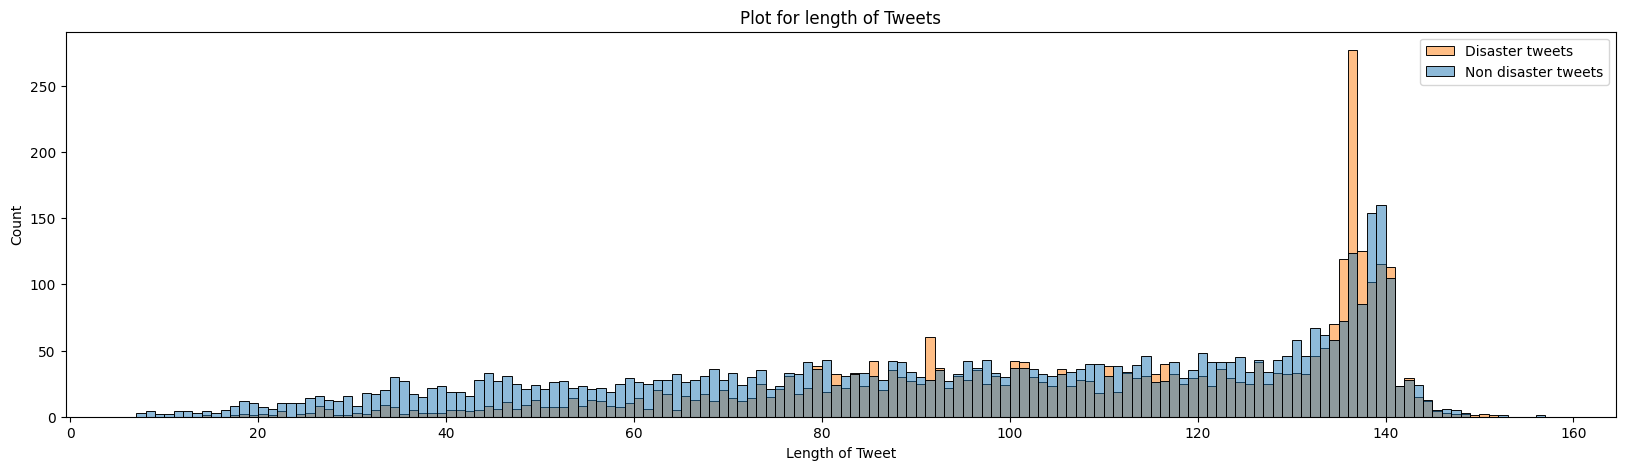

In [9]:
tweets['Length of Tweet'] = tweets['text'].apply(lambda x: len(x))

fig, ax = plt.subplots(figsize = (20, 5))
sns.histplot(x = 'Length of Tweet', data=tweets, hue="target", bins=150)

plt.title('Plot for length of Tweets')
plt.legend(labels=['Disaster tweets', 'Non disaster tweets'])
plt.show()

Most tweets are generally around the typical 140 character limit range. We now plot the average word length for the tweets

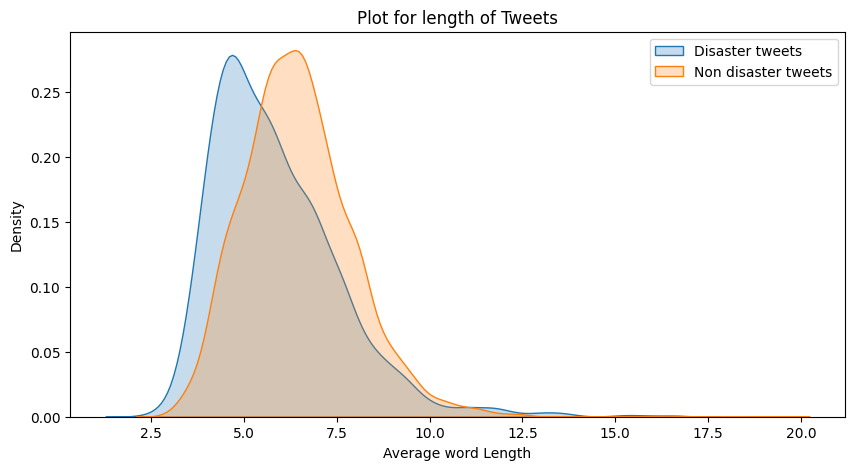

In [10]:
tweets['Average word Length'] = tweets['text'].apply(lambda x: np.mean([len(i) for i in x.split()]))

fig, ax = plt.subplots(figsize = (10, 5))
# sns.kdeplot(x = 'Average word Length', data = tweets, shade = True, hue="target")
sns.kdeplot(tweets['Average word Length'][tweets['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(tweets['Average word Length'][tweets['target'] == 1], shade = True, label = 'Disaster tweet')

plt.title('Plot for length of Tweets')
plt.legend(labels=['Disaster tweets', 'Non disaster tweets'])
plt.show()

Most tweets have words around 3 to 7 characters long, with disaster tweets having longer words compared to non disaster tweets. Now that we have a good idea of the word and character distributions, we can move on to preprocessing the data

## Data Preprocessing

In [11]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

lem = WordNetLemmatizer()
def lemmatize_words(text):
    text = ' '.join(lem.lemmatize(word) for word in text.split(' '))
    return text

def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text

In [12]:
tweets['text'] = tweets['text'].apply(lambda x : remove_URL(x))
tweets['text'] = tweets['text'].apply(lambda x : remove_html(x))
tweets['text'] = tweets['text'].apply(lambda x : remove_emoji(x))
tweets['text'] = tweets['text'].apply(lambda x : remove_punct(x))
tweets['text'] = tweets['text'].apply(lambda x : x.lower())
tweets['text'] = tweets['text'].apply(lambda x : lemmatize_words(x))
tweets['text'] = tweets['text'].apply(lambda x : remove_stopwords(x))

test_data['text'] = test_data['text'].apply(lambda x : remove_URL(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_html(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_emoji(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_punct(x))
test_data['text'] = test_data['text'].apply(lambda x : x.lower())
test_data['text'] = test_data['text'].apply(lambda x : lemmatize_words(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_stopwords(x))

In [13]:
tweets.head()

,id,keyword,location,text,target,Count of Words,Length of Tweet,Average word Length
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,13,69,4.384615
1,4,NaN,NaN,forest fire near la ronge sask canada,1,7,38,4.571429
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,22,133,5.090909
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,8,65,7.125000
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,16,88,4.500000


## Wordclouds
Displaying wordcloud for non-disaster tweets

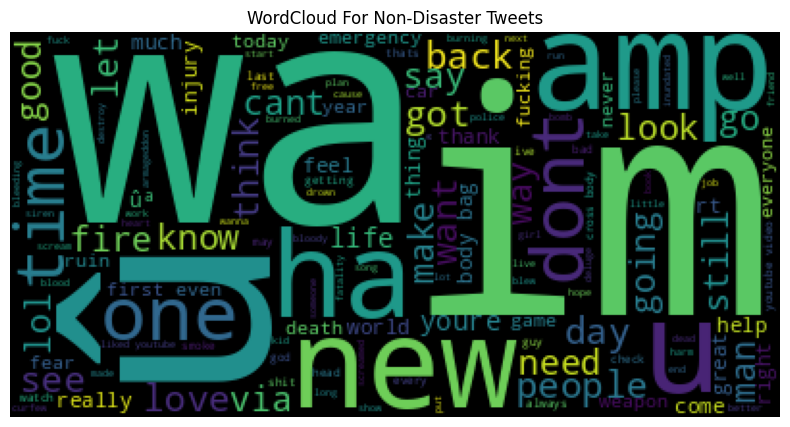

In [14]:
plt.figure(figsize=(10,5))
word_cloud = WordCloud(background_color = 'black').generate(" ".join(tweets[tweets['target']==0]['text']))
plt.imshow(word_cloud)
plt.axis("off")
plt.title("WordCloud For Non-Disaster Tweets")
plt.show()  

Displaying wordcloud for disaster tweets

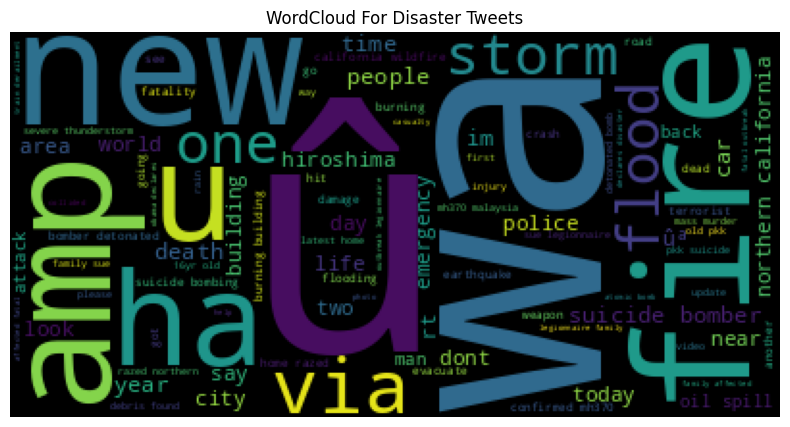

In [15]:
plt.figure(figsize=(10,5))
word_cloud = WordCloud(background_color = 'black').generate(" ".join(tweets[tweets['target']==1]['text']))
plt.imshow(word_cloud)
plt.axis("off")
plt.title("WordCloud For Disaster Tweets")
plt.show()  

Now we move on to the machine learning model training

In [16]:
# Creating a table to track results
results = pd.DataFrame(columns=[
                    "Experiment Name", 
                    "Cross fold train F1", 
                    "Val F1", 
                    "Val Acc",
                    "Train Taken (s)", 
                    "Test Time (s)"
            ])

## Baseline Logistic Regression

In [17]:
tfidf = TfidfVectorizer()

In [18]:
X_train = tfidf.fit_transform(tweets["text"])
y_train = tweets["target"]
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [19]:
lr = LogisticRegression()

start = time()
lr.fit(X_train, y_train)
train_time = round(time() - start, 3)

In [20]:
start = time()
y_pred = lr.predict(X_test)
test_time = round(time() - start, 3)

In [21]:
pred_prob = lr.predict_proba(X_test)
accuracy = lr.score(X_test, y_test)
f1 = f1_score(y_test, y_pred)

print('Accuracy of Logistic Regression on test set: {:.2f}'.format(accuracy))
print('F1 score of Logisitic Regression on test set: {:.3f}'.format(f1))

Accuracy of Logistic Regression on test set: 0.80
F1 score of Logisitic Regression on test set: 0.737


In [22]:
results.loc[0] = ["Baseline LR", 
                  "-", 
                  round(f1, 3), 
                  round(lr.score(X_test, y_test), 3), 
                  train_time, 
                  test_time
                 ]

In [23]:
results

,Experiment Name,Cross fold train F1,Val F1,Val Acc,Train Taken (s),Test Time (s)
0,Baseline LR,-,0.737,0.803,0.162,0.002


In [24]:
# Preparing data for grid search
X_train = tweets['text']
y_train = tweets['target']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=42)

## Logisitic Regression

In [26]:
lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])
    
parameters = {
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga'],
    'clf__penalty': ('l1', 'l2'),
    'clf__C': (10, 1, 0.1, 0.01),
    'clf__max_iter': (50, 80, 200),
}
    
# K fold 
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

lr_gs = GridSearchCV(lr_pipe, parameters, scoring = 'f1', cv = strat_kf, n_jobs=-1, verbose = 2)
lr_gs.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=True; total time=   7.7s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   1.5s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   1.5s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=False; total time=   1.3s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, t

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   5.1s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.4s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.2s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   9.3s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=True; total time=   2.3s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__so

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.3s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=True; total time=   7.7s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   1.5s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   1.6s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=False; total time=   1.3s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfi

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.4s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.5s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   9.3s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   1.5s
[CV] END clf__C=10, clf__max_iter=50, clf__penalty=l1, clf__solv

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=10, clf__max_iter=200, clf__penalty=l2, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__C=10, clf__max_iter=200, clf__penalty=l2, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__C=10, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__C=10, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__C=10, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__C=10, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.2s
[CV] END clf__C=10, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.2s
[CV] END clf__C=10, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tf

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=15, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': (10, 1, 0.1, 0.01),
                         'clf__max_iter': (50, 80, 200),
                         'clf__penalty': ('l1', 'l2'),
                         'clf__solver': ['liblinear', 'saga'],
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__use_idf': [True, False]},
             scoring='f1', verbose=2)

In [27]:
print("F1 score for the model with best parameters:", round(lr_gs.best_score_, 3))
print("Best parameters: ", lr_gs.best_params_)

F1 score for the model with best parameters: 0.734
Best parameters:  {'clf__C': 1, 'clf__max_iter': 50, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__norm': 'l2', 'tfidf__use_idf': False}


In [28]:
# Best estimator fitting time
start = time()
lr_gs.best_estimator_.fit(X_train, y_train)
train_time = round(time() - start, 4)

In [29]:
start = time()
y_pred = lr_gs.best_estimator_.predict(X_test)
test_time = round(time() - start, 3)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score on the test set: ", round(accuracy, 3))
print("F1 Score on the test set: ", round(f1, 3))

Accuracy Score on the test set:  0.812
F1 Score on the test set:  0.764


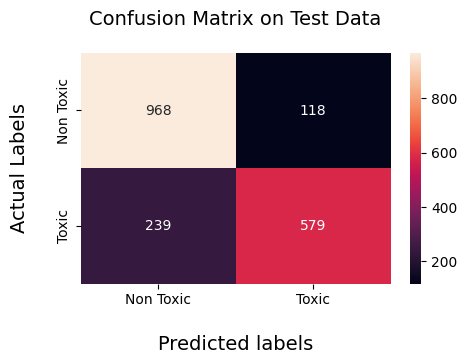

In [30]:
# Building a confusion matric on the test data
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5,3))

ax = sns.heatmap(conf_mat, annot=True, fmt=".0f")

# set x-axis label and ticks.
ax.set_xlabel("Predicted labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Non Toxic', 'Toxic'])

# set y-axis label and ticks
ax.set_ylabel("Actual Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Non Toxic', 'Toxic'])

ax.set_title("Confusion Matrix on Test Data", fontsize=14, pad=20)

plt.show()

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1086
           1       0.83      0.71      0.76       818

    accuracy                           0.81      1904
   macro avg       0.82      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



In [32]:
results.loc[len(results)] = [
        "Logistic Regression", 
        round(lr_gs.best_score_, 3), 
        round(f1, 3),
        round(accuracy, 3),
        train_time,
        test_time
]

In [33]:
results

,Experiment Name,Cross fold train F1,Val F1,Val Acc,Train Taken (s),Test Time (s)
0,Baseline LR,-,0.737,0.803,0.1620,0.002
1,Logistic Regression,0.734,0.764,0.812,0.1019,0.027


## SGD Classifier

In [34]:
sgd_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SGDClassifier())
])
    
parameters = {
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'clf__loss': ('hinge', 'perceptron', 'log_loss'),
    'clf__penalty': ('l1', 'l2', 'elasticnet'),
    'clf__tol': (0.0001, 0.00001, 0.0000001), 
    'clf__alpha': (0.1, 0.01, 0.001, 0.0001), 
}

    
# K fold 
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    
sgd_gs = GridSearchCV(sgd_pipe, parameters, scoring = 'f1', cv = strat_kf, n_jobs=-1, verbose = 2)
sgd_gs.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__C=0.01, clf__max_iter=50, clf__pena

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.2s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__C=0.01, clf__max_iter=50, clf__penalty=l2, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.2s
[CV] END clf__C=0.01, clf__max_iter=80, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__C=0.01, clf__max_iter=80, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__C=0.01, clf__max_iter=80, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__C=0.01, clf__max_iter=80, clf__penalty=l1, clf__solver=liblinear, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__C=0.01, clf__max_iter=80, clf__penalty=l1, cl

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic


[CV] END clf__C=0.01, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__C=0.01, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.2s
[CV] END clf__C=0.01, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__C=0.01, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__C=0.01, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=hinge, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=hinge, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=hinge, clf__penalty=l1, clf__tol=0.00

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptro

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.2s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=l2, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=percept

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=True; to

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=False; to

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalty=l2, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalty=l2, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalty=l2, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalty=l2, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalty=l2, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.1, clf__loss=log_loss, clf__penalt

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.01, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.01, clf__loss=log_loss, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.01, clf__loss=log_loss, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.01, clf__loss=log_loss, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.01, clf__loss=log_loss, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.01, clf__loss=log_loss, clf__penalty=l1, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.01, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.01, clf__loss=

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=l2, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=0.0001, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=Tru

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.3s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=False; total time=   1.3s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.001, clf__loss=log_loss, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=True; total time=   1.3s
[CV] END clf__alpha=0.001, clf__loss=log_loss,

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.2s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=l1, clf__tol=1e-07, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.2s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=l2, clf__tol=0.0001, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=15, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.1, 0.01, 0.001, 0.0001),
                         'clf__loss': ('hinge', 'perceptron', 'log_loss'),
                         'clf__penalty': ('l1', 'l2', 'elasticnet'),
                         'clf__tol': (0.0001, 1e-05, 1e-07),
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__use_idf': [True, False]},
             scoring='f1', verbose=2)

In [35]:
print("F1 score for the model with best parameters:", round(sgd_gs.best_score_, 3))
print("Best parameters: ", sgd_gs.best_params_)

F1 score for the model with best parameters: 0.742
Best parameters:  {'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'l2', 'clf__tol': 1e-05, 'tfidf__norm': 'l2', 'tfidf__use_idf': True}


In [36]:
# Best estimator fitting time
start = time()
sgd_gs.best_estimator_.fit(X_train, y_train)
train_time = round(time() - start, 4)

In [37]:
start = time()
y_pred = sgd_gs.best_estimator_.predict(X_test)
test_time = round(time() - start, 3)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score on the test set: ", round(accuracy, 3))
print("F1 Score on the test set: ", round(f1, 3))

Accuracy Score on the test set:  0.814
F1 Score on the test set:  0.768


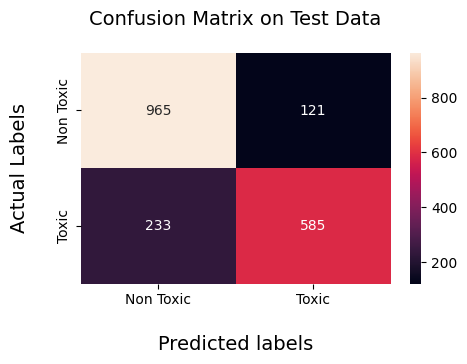

In [38]:
# Building a confusion matric on the test data
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5,3))

ax = sns.heatmap(conf_mat, annot=True, fmt=".0f")

# set x-axis label and ticks.
ax.set_xlabel("Predicted labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Non Toxic', 'Toxic'])

# set y-axis label and ticks
ax.set_ylabel("Actual Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Non Toxic', 'Toxic'])

ax.set_title("Confusion Matrix on Test Data", fontsize=14, pad=20)

plt.show()

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1086
           1       0.83      0.72      0.77       818

    accuracy                           0.81      1904
   macro avg       0.82      0.80      0.81      1904
weighted avg       0.82      0.81      0.81      1904



In [40]:
results.loc[len(results)] = [
        "Stochastic GD Classifier", 
        round(sgd_gs.best_score_, 3),  
        round(f1, 3),
        round(accuracy, 3),
        train_time,
        test_time
]

In [41]:
results

,Experiment Name,Cross fold train F1,Val F1,Val Acc,Train Taken (s),Test Time (s)
0,Baseline LR,-,0.737,0.803,0.1620,0.002
1,Logistic Regression,0.734,0.764,0.812,0.1019,0.027
2,Stochastic GD Classifier,0.742,0.768,0.814,0.1574,0.021


## Random Forest Classifier

In [42]:
rfc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])
    
parameters = {
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'clf__max_depth': [None, 9, 15, 22],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [2, 5, 10],
    'clf__n_estimators':[80, 150, 200],
    'clf__criterion':['gini','entropy']
}

# K fold 
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    
rfc_gs = GridSearchCV(rfc_pipe, parameters, scoring = 'f1', cv = strat_kf, n_jobs=-1, verbose = 2)
rfc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.1s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.1s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-05, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.2s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, clf__penalty=elasticnet, clf__tol=1e-07, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.2s
[CV] END clf__alpha=0.0001, clf__loss=perceptron, cl

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=15, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [None, 9, 15, 22],
                         'clf__min_samples_leaf': [2, 5, 10],
                         'clf__min_samples_split': [2, 5, 10],
                         'clf__n_estimators': [80, 150, 200],
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__use_idf': [True, False]},
             scoring='f1', verbose=2)

In [43]:
print("Score for the model with best parameters:", round(rfc_gs.best_score_, 3))
print("Best parameters: ", rfc_gs.best_params_)

Score for the model with best parameters: 0.739
Best parameters:  {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}


In [44]:
# Best estimator fitting time
start = time()
rfc_gs.best_estimator_.fit(X_train, y_train)
train_time = round(time() - start, 4)

In [45]:
start = time()
y_pred = rfc_gs.best_estimator_.predict(X_test)
test_time = round(time() - start, 3)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score on the test set: ", round(accuracy, 3))
print("F1 Score on the test set: ", round(f1, 3))

Accuracy Score on the test set:  0.798
F1 Score on the test set:  0.756


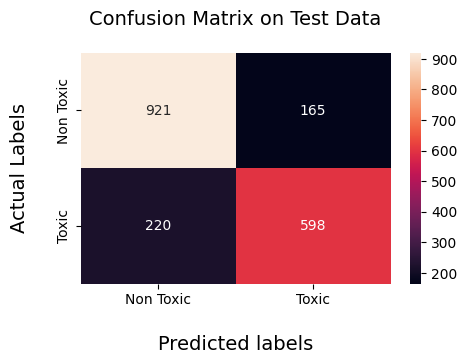

In [46]:
# Building a confusion matric on the test data
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5,3))

ax = sns.heatmap(conf_mat, annot=True, fmt=".0f")

# set x-axis label and ticks.
ax.set_xlabel("Predicted labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Non Toxic', 'Toxic'])

# set y-axis label and ticks
ax.set_ylabel("Actual Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Non Toxic', 'Toxic'])

ax.set_title("Confusion Matrix on Test Data", fontsize=14, pad=20)

plt.show()

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1086
           1       0.78      0.73      0.76       818

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904



In [48]:
results.loc[len(results)] = [
        "Random Forest Classifier", 
        round(rfc_gs.best_score_, 3), 
        round(f1, 3),
        round(accuracy, 3),
        train_time,
        test_time
]

In [49]:
results

,Experiment Name,Cross fold train F1,Val F1,Val Acc,Train Taken (s),Test Time (s)
0,Baseline LR,-,0.737,0.803,0.1620,0.002
1,Logistic Regression,0.734,0.764,0.812,0.1019,0.027
2,Stochastic GD Classifier,0.742,0.768,0.814,0.1574,0.021
3,Random Forest Classifier,0.739,0.756,0.798,5.7275,0.238


## Support Vector Classifier

In [50]:
svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC())
])
    
parameters = {
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'clf__kernel': ('rbf', 'poly'),     
    'clf__degree': (1, 2, 3, 4, 5),
    'clf__C': (10, 1, 0.1, 0.01),
}


# K fold 
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    
svc_gs = GridSearchCV(svc_pipe, parameters, scoring = 'f1', cv = strat_kf, n_jobs=-1, verbose = 2)
svc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] END clf__criterion=entropy, clf__max_depth=22, clf__min_samples_leaf=10, clf__min_samples_split=5, clf__n_estimators=80, tfidf__norm=l1, tfidf__use_idf=True; total time=   0.6s
[CV] END clf__criterion=entropy, clf__max_depth=22, clf__min_samples_leaf=10, clf__min_samples_split=5, clf__n_estimators=80, tfidf__norm=l1, tfidf__use_idf=False; total time=   0.7s
[CV] END clf__criterion=entropy, clf__max_depth=22, clf__min_samples_leaf=10, clf__min_samples_split=5, clf__n_estimators=80, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.5s
[CV] END clf__criterion=entropy, clf__max_depth=22, clf__min_samples_leaf=10, clf__min_samples_split=5, clf__n_estimators=80, tfidf__norm=l2, tfidf__use_idf=True; total time=   0.5s
[CV] END clf__criterion=entropy, clf__max_depth=22, clf__min_samples_leaf=10, clf__min_samples_split=5, clf__n_estimators=80, tfidf__norm=l2, tfidf__use_idf=False; total time=   0.5s
[CV] END clf__criterion=e

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=15, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', SVC())]),
             n_jobs=-1,
             param_grid={'clf__C': (10, 1, 0.1, 0.01),
                         'clf__degree': (1, 2, 3, 4, 5),
                         'clf__kernel': ('rbf', 'poly'),
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__use_idf': [True, False]},
             scoring='f1', verbose=2)

In [51]:
print("Score for the model with best parameters:", round(svc_gs.best_score_, 3))
print("Best parameters: ", svc_gs.best_params_)

Score for the model with best parameters: 0.741
Best parameters:  {'clf__C': 1, 'clf__degree': 1, 'clf__kernel': 'poly', 'tfidf__norm': 'l2', 'tfidf__use_idf': False}


In [52]:
# Best estimator fitting time
start = time()
svc_gs.best_estimator_.fit(X_train, y_train)
train_time = round(time() - start, 4)

In [53]:
start = time()
y_pred = svc_gs.best_estimator_.predict(X_test)
test_time = round(time() - start, 3)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score on the test set: ", round(accuracy, 3))
print("F1 Score on the test set: ", round(f1, 3))

Accuracy Score on the test set:  0.81
F1 Score on the test set:  0.765


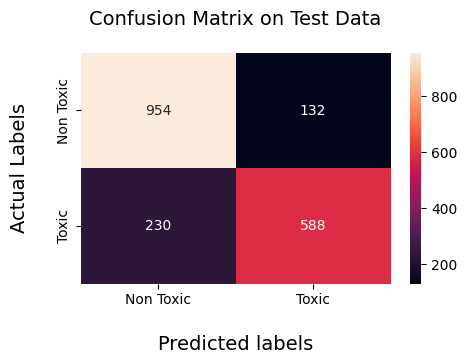

In [54]:
# Building a confusion matric on the test data
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5,3))

ax = sns.heatmap(conf_mat, annot=True, fmt=".0f")

# set x-axis label and ticks.
ax.set_xlabel("Predicted labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Non Toxic', 'Toxic'])

# set y-axis label and ticks
ax.set_ylabel("Actual Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Non Toxic', 'Toxic'])

ax.set_title("Confusion Matrix on Test Data", fontsize=14, pad=20)

plt.show()

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1086
           1       0.82      0.72      0.76       818

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



In [56]:
results.loc[len(results)] = [
        "Support Vector Classifier", 
        round(svc_gs.best_score_, 3), 
        round(f1, 3),
        round(accuracy, 3),
        train_time,
        test_time
]

In [57]:
results

,Experiment Name,Cross fold train F1,Val F1,Val Acc,Train Taken (s),Test Time (s)
0,Baseline LR,-,0.737,0.803,0.1620,0.002
1,Logistic Regression,0.734,0.764,0.812,0.1019,0.027
2,Stochastic GD Classifier,0.742,0.768,0.814,0.1574,0.021
3,Random Forest Classifier,0.739,0.756,0.798,5.7275,0.238
4,Support Vector Classifier,0.741,0.765,0.810,1.9668,0.444


## Voting Classifier
Here I will take the 4 models and run them through a voting classifier

In [58]:
lr_vc = lr_gs.best_estimator_
sgd_vc = sgd_gs.best_estimator_
rfc_vc = rfc_gs.best_estimator_
svc_vc = svc_gs.best_estimator_

estimators = [
    ('lr', lr_vc), 
    ('sgd', sgd_vc), 
    ('rfc', rfc_vc),
    ('svc', sgd_vc)
]

In [59]:
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

vc_clf = VotingClassifier(estimators=estimators, voting='hard')
scores = cross_val_score(vc_clf, X_train, y_train, scoring='f1', cv=strat_kf)

start = time()
print('F1 Score on training set: ', round(scores.mean(), 3))
ensemble_model = vc_clf.fit(X_train, y_train)
train_time = round(time() - start, 3)

start = time()
y_pred = ensemble_model.predict(X_test)
test_time = round(time() - start, 3)

F1 Score on training set:  0.74


In [60]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score on the test set: ", round(accuracy, 3))
print("F1 Score on the test set: ", round(f1, 3))

Accuracy Score on the test set:  0.814
F1 Score on the test set:  0.766


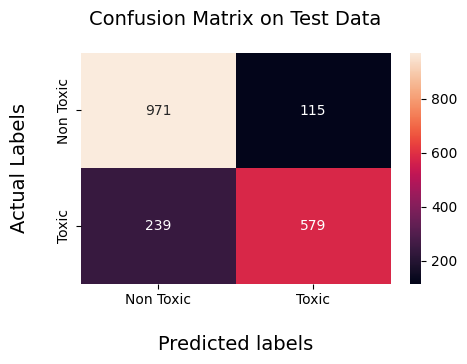

In [61]:
# Building a confusion matric on the test data
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5,3))

ax = sns.heatmap(conf_mat, annot=True, fmt=".0f")

# set x-axis label and ticks.
ax.set_xlabel("Predicted labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Non Toxic', 'Toxic'])

# set y-axis label and ticks
ax.set_ylabel("Actual Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Non Toxic', 'Toxic'])

ax.set_title("Confusion Matrix on Test Data", fontsize=14, pad=20)

plt.show()

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.85      1086
           1       0.83      0.71      0.77       818

    accuracy                           0.81      1904
   macro avg       0.82      0.80      0.81      1904
weighted avg       0.82      0.81      0.81      1904



In [63]:
results.loc[len(results)] = [
        "Voting Classifier", 
        round(scores.mean(), 3),
        round(f1, 3),
        round(accuracy, 3),
        train_time,
        test_time
]

In [64]:
results

,Experiment Name,Cross fold train F1,Val F1,Val Acc,Train Taken (s),Test Time (s)
0,Baseline LR,-,0.737,0.803,0.1620,0.002
1,Logistic Regression,0.734,0.764,0.812,0.1019,0.027
2,Stochastic GD Classifier,0.742,0.768,0.814,0.1574,0.021
3,Random Forest Classifier,0.739,0.756,0.798,5.7275,0.238
4,Support Vector Classifier,0.741,0.765,0.810,1.9668,0.444
5,Voting Classifier,0.74,0.766,0.814,6.0790,0.319


## Generating Test Predictions

In [65]:
X_train, y_train = tweets['text'], tweets['target']
X_test = test_data['text']

In [66]:
ensemble_model = vc_clf.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)
test_data['target'] = y_pred
test_data.drop(['text','keyword','location'], axis=1, inplace=True)

In [67]:
test_data.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [68]:
test_data.to_csv('submission.csv', index=False)